# A Bidirectional Graph-Search Algorithm

We had some trouble with the slow identification of "simple paths" and "shortest paths" in our application, whereby we applied the common networkx library for python. We therefore developed our own bidirectional path search algorithms that performs much better and especially on large graphs, for which we want provide a small benchmark at this post.

The algorithms can currently be downloaded under the following link

https://github.com/andre-dietrich/networkx/blob/master/networkx/algorithms/bidirectional_path_search.py

... we hope that these little helpers can be integrated into the networkx library.

## In principle

This algorithm depicted below constructs sequentially two trees, one from the source in direction to the target and one from the target in direction to the source. The leaves of both growing trees are continuously compared, if there are matching leaves in both trees, a new path is identified. Doing this, the algorithm actually reduces the search space by half, which should result in a faster identification of simple paths and shortest paths, compared to the original `nx.all_simple_paths` and  `nx.all_shortest_paths` algorithms (which are currently included in the networkx library). As revealed by the benchmark, this bidirectional search approach performs performs better for sparse trees, the more connected a graph is, the less beneficial is our approach.Another advantage is, that the results are returned in order, starting from the shortest paths, which are afterwards incremented stepwise in length.

## Usage

The principle of the bidirectional search was implemented for three common search tasks (`has_path`, `all_shortest_paths`, `all_simple_paths`). The application is briefly introduced within this section, before the three approaches are compared against their `networkx` counterparts.

Populating the interactive namespace from numpy and matplotlib


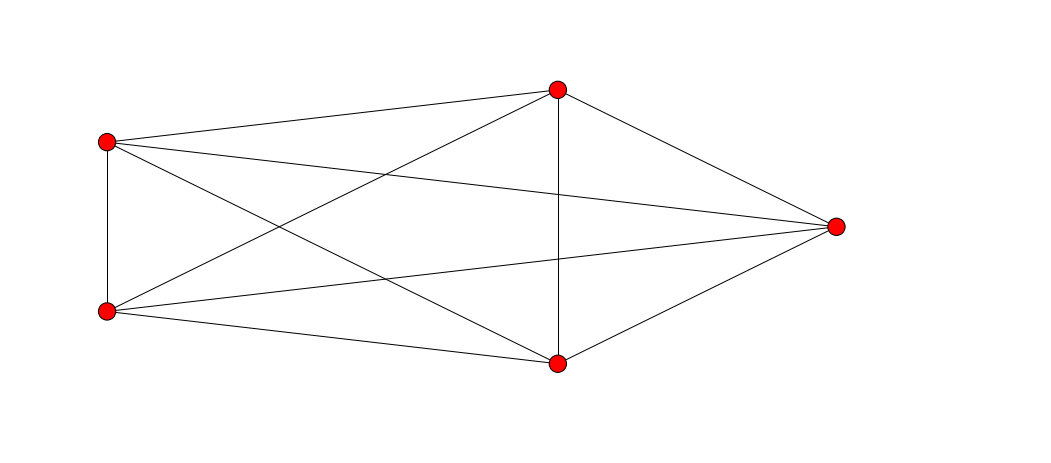

In [1]:
%pylab inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14.0, 6.0)

import networkx as nx
G = nx.complete_graph(5)
 
import matplotlib.pyplot as plt
nx.draw_circular(G)

### 1. all_simple_paths

This function is used to search for all simple paths. A simple path, by definition, is a path with no repeated nodes. As visible in the example below, one benefit of the bidirectional approach is that all results are generated in order.

In [2]:
for path in nx.bidirectional_all_simple_paths(G, source=0, target=4):
    print(path)

[0, 4]
[0, 1, 4]
[0, 2, 4]
[0, 3, 4]
[0, 1, 2, 4]
[0, 1, 3, 4]
[0, 2, 1, 4]
[0, 2, 3, 4]
[0, 3, 1, 4]
[0, 3, 2, 4]
[0, 3, 1, 2, 4]
[0, 2, 1, 3, 4]
[0, 3, 2, 1, 4]
[0, 1, 2, 3, 4]
[0, 2, 3, 1, 4]
[0, 1, 3, 2, 4]


A similar example below, shows a the usage of the cutoff parameter, which is used to define a maximal path length

In [3]:
paths = nx.bidirectional_all_simple_paths(G, 0, 4,cutoff=2)
print(list(paths))

[[0, 4], [0, 1, 4], [0, 2, 4], [0, 3, 4]]


### 2. all_shortest_paths

`all_shortest_paths` is used similarly ... However, the implementation of this function contains some optimizations that cannot be applied in `all_simple_paths`, making it even faster.

In [4]:
for path in nx.bidirectional_all_shortest_paths(G, 0, 4):
    print(path)

[0, 4]


### 3. has_path

With this function we tried to port our concept onto a simple check of wheather a path between two nodes exists or not.

In [5]:
print nx.bidirectional_has_path(G, source=0, target=4)

True


### 4. Note

All of the presented algorithms can be applied in the same way also for directed graphs and multigraphs.

## Benchmark against networkx

The following benchmark is used to test the bidirectional approach against the implementation applied in networkx. For the test we applied the huge and dense graph that is generated below.

In [6]:
import time
import random
 
# trying out a huge graph...
G1 = nx.dense_gnm_random_graph(20000,20000,2)
print nx.info(G1)

Name: dense_gnm_random_graph(20000,20000)
Type: Graph
Number of nodes: 20000
Number of edges: 20000
Average degree:   2.0000


### 1. has_path – nearly equal (slightly)

As this first test reveals that our approach for `has_path` performs only better for large graphs. In the case that no path exists, our approach seems to be faster, while for the other case both algorithms are nearly equal.

In [7]:
times1, times2 = [[], []], [[],[]]
#lengts2, lengths2 = [], []
for i in range(100000):
    source = random.randint(0, len(G1)-1)
    target = random.randint(0, len(G1)-1)
    
    # original
    t = time.time()
    r = nx.has_path(G1, source, target)
    t = times1[r].append(time.time()-t)
    
    # bidirectional
    t = time.time()
    r = nx.bidirectional_has_path(G1, source, target)
    times2[r].append(time.time()-t)

In [8]:
print "mean NetworkX:      found(", mean(times1[1]), "), not found(", mean(times1[0]), ")"
print "mean Bidirectional: found(", mean(times2[1]), "), not found(", mean(times2[0]), ")"

mean NetworkX:      found( 0.00023715649866 ), not found( 1.06433424291e-05 )
mean Bidirectional: found( 0.00023341340516 ), not found( 8.0156769307e-06 )


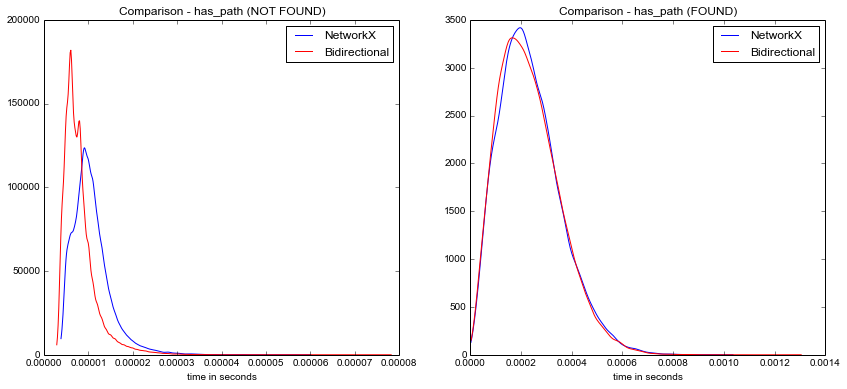

In [9]:
from scipy.stats import gaussian_kde
from numpy import linspace

plt.subplot(121)
plt.title("Comparison - has_path (NOT FOUND)")
plt.xlabel("time in seconds")

density1 = gaussian_kde(times1[0])
xs1 = linspace(min(times1[0]), max(times1[0]), 500)
plt.plot(xs1, density1(xs1), label="NetworkX", color="blue")
density2 = gaussian_kde(times2[0])
xs2 = linspace(min(times2[0]), max(times2[0]), 500)
plt.plot(xs2, density2(xs2), label="Bidirectional", color="red")
plt.legend()
plt.subplot(122)

plt.title("Comparison - has_path (FOUND)")
plt.xlabel("time in seconds")

density3 = gaussian_kde(times1[1])
xs3 = linspace(min(times1[1]), max(times1[1]), 500)
plt.plot(xs3, density3(xs3), label="NetworkX", color="blue")
density4 = gaussian_kde(times2[1])
xs4 = linspace(min(times2[1]), max(times2[1]), 500)
plt.plot(xs4, density4(xs4), label="Bidirectional", color="red")
plt.legend()

plt.show()

### 2. all_shortest_paths – win (approx. 60times faster)

In contrast to the previous approach, we now really perform much better, if it is about identifying all shortest paths within the graph. As you see from the mean value and mainly in the diagrams below, even with our worst approach we are below the minimum of the original search algorithm.

In [10]:
times1, times2     = [], []
results1, results2 = [], []
lengths1, lengths2 = [], []
for i in range(2000):
    source = random.randint(0, len(G1)-1)
    target = random.randint(0, len(G1)-1)
     
    if not nx.has_path(G1, source, target):
        continue
     
    # bidirectional
    t = time.time()
    res = list(nx.bidirectional_all_shortest_paths(G1, source, target))
    times2.append(time.time()-t)
    results2.append(len(res))
    lengths2.append(len(res[0]))
     
    # original
    t = time.time()
    res = list(nx.all_shortest_paths(G1, source, target))
    times1.append(time.time()-t)
    results1.append(len(res))
    lengths1.append(len(res[0]))

In [11]:
print "NetworkX:     ", mean(times1)
print "Bidirectional:", mean(times2)

NetworkX:      0.0339231790525
Bidirectional: 0.000487153940668


This difference becomes even more visible, when plotting the resulting times against the lengths of the shortest paths. It is still a mystery for us, why there are two clusters within the original algorithm.

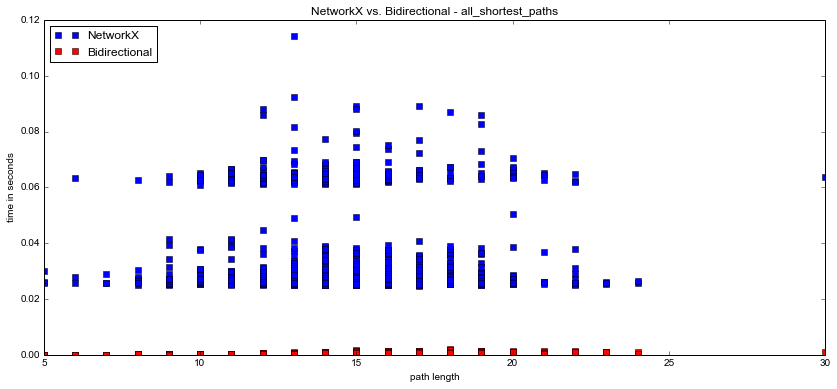

In [12]:
plt.plot(lengths1, times1, 'bs', label="NetworkX")
plt.plot(lengths2, times2, 'rs', label="Bidirectional")
plt.legend(loc="upper left")
plt.xlabel("path length")
plt.ylabel("time in seconds")
plt.title("NetworkX vs. Bidirectional - all_shortest_paths")
plt.show()

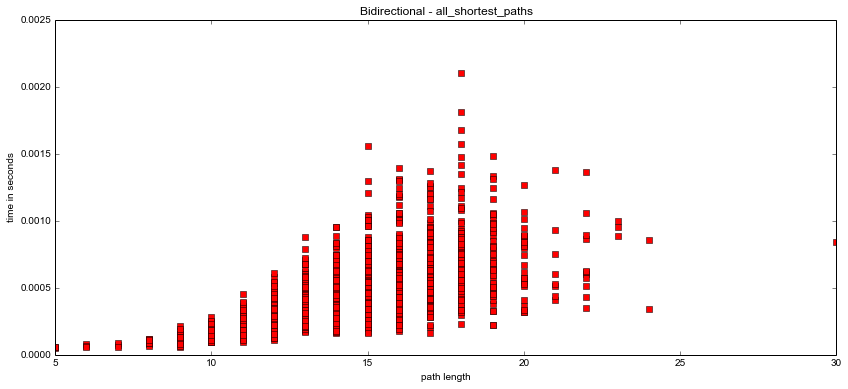

In [13]:
plt.plot(lengths2, times2, 'rs')
plt.xlabel("path length")
plt.ylabel("time in seconds")
plt.title("Bidirectional - all_shortest_paths")
plt.show()

### 3. `all_simple_paths` – the winner takes it all

Within the following we test how long it takes to identify all simple paths within the graph that have a certain length (cutoff).

We adapted our previous implementation and were suprised that it performs so good. For all simple paths, the bidirectional approach works better and with nearly linear time increase compared to the number of generated results. 

In [14]:
import pandas

df = pandas.DataFrame(columns=["T bi", "R bi", "T nx", "R nx", "T yen", "R yen"])

node1 = 4; node2 = 1999
for i in range(36):
    res = dict()
    
    # original
    if df["T nx"].tail(1).any() < 50:
        t = time.time()
        r = list(nx.all_simple_paths(G1, node1, node2, cutoff=i))
        res["T nx"] = time.time()-t
        res["R nx"] = len(r)
    
    # bidirectional
    if df["T bi"].tail(1).any() < 50:
        t = time.time()
        r = list(nx.bidirectional_all_simple_paths(G1, node1, node2, cutoff=i))
        res["T bi"] = time.time()-t
        res["R bi"] = len(r)
        
    # Yen
    if df["T yen"].tail(1).any() < 50:
        t = time.time()
        r = []
        for path in nx.shortest_simple_paths(G1, node1, node2):
            if len(path) > i+1: break
            r.append(path)
        res["T yen"] = time.time()-t
        res["R yen"] = len(r)
    
    df=df.append(res, ignore_index=True)
df

,T bi,R bi,T nx,R nx,T yen,R yen
0,1.001358e-05,0,2.503395e-05,0,0.0007040501,0
1,3.099442e-05,0,1.502037e-05,0,0.0003271103,0
2,3.218651e-05,0,2.503395e-05,0,0.0002839565,0
3,4.291534e-05,0,4.291534e-05,0,0.0002799034,0
4,0.0001120567,0,9.584427e-05,0,0.0002939701,0
5,8.201599e-05,0,0.0001678467,0,0.0002710819,0
6,0.000109911,0,0.0004870892,0,0.0002551079,0
7,0.0001709461,0,0.0009920597,0,0.0006840229,0
8,0.000235796,0,0.002131939,0,0.0002880096,0
9,0.000387907,0,0.004599094,0,0.0003249645,0


Plotting the result on a logarithmic scale ...

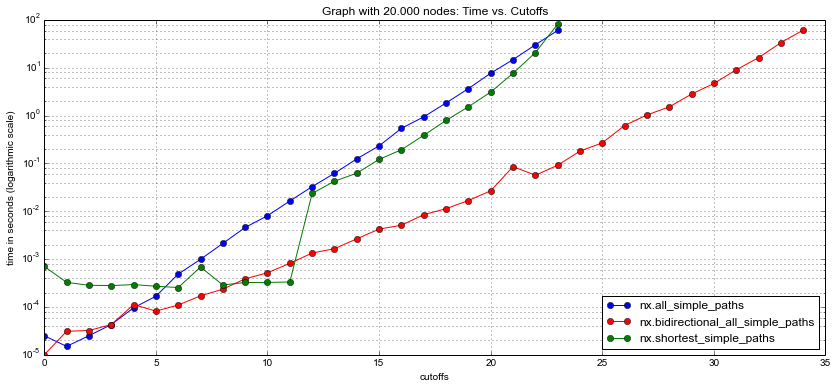

In [17]:
plt.title("Graph with 20.000 nodes: Time vs. Cutoffs")
plt.ylabel("time in seconds (logarithmic scale)")
plt.xlabel("cutoffs")

df["T nx"].plot(color = "b",  linestyle='-', marker='o', label="nx.all_simple_paths")
df["T bi"].plot(color = "r",  linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
df["T yen"].plot(color = "g", linestyle='-', marker='o', label="nx.shortest_simple_paths")

plt.yscale('log')
plt.legend(loc="lower right")
plt.grid(True, which="both")
plt.show()

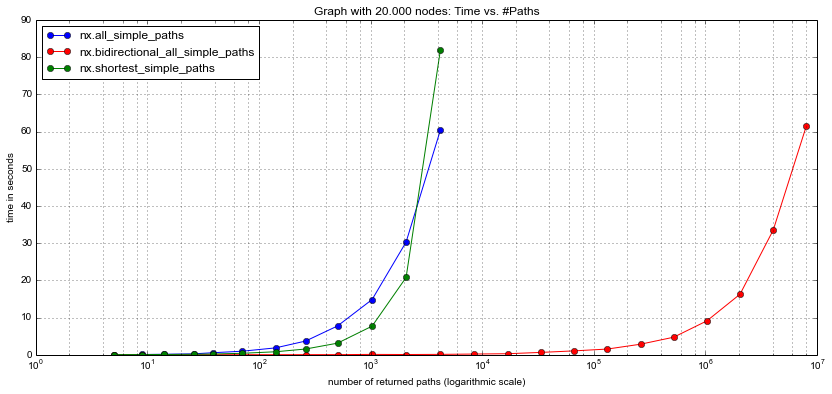

In [18]:
plt.title("Graph with 20.000 nodes: Time vs. #Paths")

df.plot(x="R nx", y="T nx", color = "b",  linestyle='-', marker='o', label="nx.all_simple_paths")
df.plot(x="R bi", y="T bi", color = "r",  linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
df.plot(x="R yen",y="T yen",color = "g",  linestyle='-', marker='o', label="nx.shortest_simple_paths")

plt.ylabel("time in seconds")
plt.xlabel("number of returned paths (logarithmic scale)")

plt.xscale('log')
plt.legend(loc="upper left")
plt.grid(True, which="both")
plt.show()

The same is surprisingly achieved for samller graphs and a higher connectivity....

In [19]:
from networkx.utils import powerlaw_sequence
from networkx.utils import create_degree_sequence
 
def pick_nodes(G):
    u = next(G.nodes())
    v = next(nx.non_neighbors(G, u))
    return u, v
 
def build_power_law(n):
    deg_seq = create_degree_sequence(n, powerlaw_sequence, 100)
    G = nx.Graph(nx.configuration_model(deg_seq))
    G.remove_edges_from(G.selfloop_edges())
    G = max(nx.biconnected_component_subgraphs(G), key=len)
    G.name = 'Biconnected comp. of power law model: {0}'.format(n)
    return G
 
G2 = build_power_law(150)
u, v = pick_nodes(G2)
print(nx.info(G2))

Name: Biconnected comp. of power law model: 150
Type: Graph
Number of nodes: 84
Number of edges: 208
Average degree:   4.9524


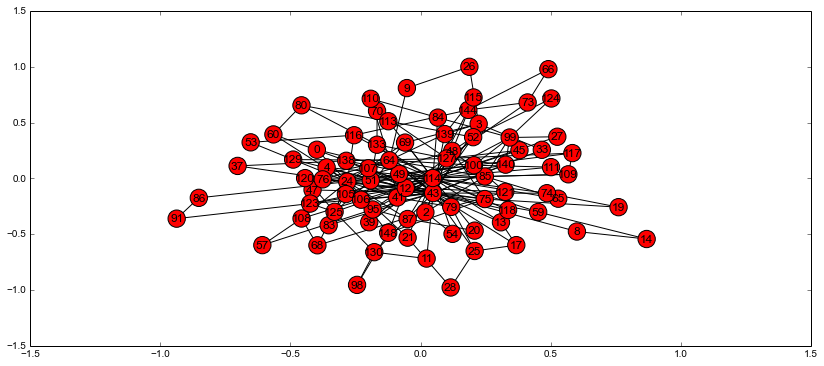

In [20]:
nx.draw_networkx(G2)

Repeating the experiment ...

In [21]:
import pandas

df2 = pandas.DataFrame(columns=["T bi", "R bi", "T nx", "R nx", "T yen", "R yen"])

for i in range(40):
    res = dict()
    
    # original
    if df2["T nx"].tail(1).any() < 20:
        t = time.time()
        r = list(nx.all_simple_paths(G1, node1, node2, cutoff=i))
        res["T nx"] = time.time()-t
        res["R nx"] = len(r)
    
    # bidirectional
    if df2["T bi"].tail(1).any() < 20:
        t = time.time()
        r = list(nx.bidirectional_all_simple_paths(G1, node1, node2, cutoff=i))
        res["T bi"] = time.time()-t
        res["R bi"] = len(r)
        
    # Yen
    if df2["T yen"].tail(1).any() < 20:
        t = time.time()
        r = []
        for path in nx.shortest_simple_paths(G1, node1, node2):
            if len(path) > i+1: break
            r.append(path)
        res["T yen"] = time.time()-t
        res["R yen"] = len(r)
    
    df2=df2.append(res, ignore_index=True)
df2

,T bi,R bi,T nx,R nx,T yen,R yen
0,1.692772e-05,0,1.435302,0,0.01182604,0
1,4.005432e-05,0,2.121925e-05,0,0.0005221367,0
2,4.005432e-05,0,3.600121e-05,0,0.0004479885,0
3,8.797646e-05,0,6.604195e-05,0,0.0005810261,0
4,0.0001261234,0,0.0001430511,0,0.0005500317,0
5,9.989738e-05,0,0.0002410412,0,0.000330925,0
6,0.0002140999,0,0.0006361008,0,0.000467062,0
7,0.0002918243,0,0.001344204,0,0.0007009506,0
8,0.0002849102,0,0.00207901,0,0.0003929138,0
9,0.000426054,0,0.005385876,0,0.0003449917,0


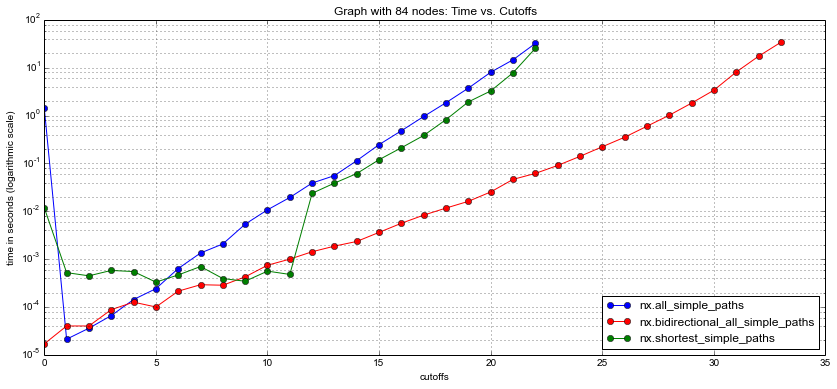

In [22]:
plt.title("Graph with 84 nodes: Time vs. Cutoffs")
plt.ylabel("time in seconds (logarithmic scale)")
plt.xlabel("cutoffs")

df2["T nx"].plot(color = "b",  linestyle='-', marker='o', label="nx.all_simple_paths")
df2["T bi"].plot(color = "r",  linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
df2["T yen"].plot(color = "g", linestyle='-', marker='o', label="nx.shortest_simple_paths")

plt.yscale('log')
plt.legend(loc="lower right")
plt.grid(True, which="both")
plt.show()

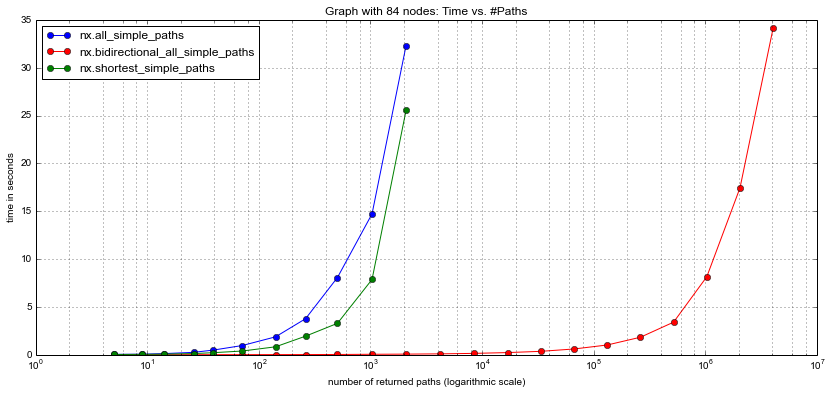

In [23]:
plt.title("Graph with 84 nodes: Time vs. #Paths")

df2.plot(x="R nx", y="T nx", color = "b",  linestyle='-', marker='o', label="nx.all_simple_paths")
df2.plot(x="R bi", y="T bi", color = "r",  linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
df2.plot(x="R yen",y="T yen",color = "g",  linestyle='-', marker='o', label="nx.shortest_simple_paths")

plt.ylabel("time in seconds")
plt.xlabel("number of returned paths (logarithmic scale)")

plt.xscale('log')
plt.legend(loc="upper left")
plt.grid(True, which="both")
plt.show()